# Direct and inverse geometry of 2d robots

This notebook the main concept of kinematic tree, direct geometry and inverse geometry, but without the kinematic tree of Pinocchio. We only use the basic geometries of the our 3d viewer for displaying the simple robot that is used in this tutorial.

In [ ]:
import magic_donotload

## Set up
We will need NumPy, SciPy, and MeshCat Viewer for vizualizing the robot.
Scipy is a collection of scientific tools for Python. It contains, in particular, a set of optimizers that we are going to use for solving the inverse-geometry problem. If not done yet, install scipy with `sudo apt-get install python3-scipy`

In [ ]:
# %load tp1/generated/configuration_reduced_import
import time
import numpy as np
from scipy.optimize import fmin_bfgs,fmin_slsqp
from utils.meshcat_viewer_wrapper import MeshcatVisualizer,translation2d,planar
from numpy.linalg import norm,inv,pinv,svd,eig


<a id='section_display_objects'></a>
## Displaying objects
Let's first learn how to open a 3D viewer, in which we will build our simulator. We will use the viewer MeshCat which directly displays in a browser. Open it as follows:

In [ ]:
viz = MeshcatVisualizer()
viz.viewer.jupyter_cell()

The following <viz> object is a client of the viewer, i.e. it will be use to pass display command to the viewer. The first commands are to create objects:

In [ ]:
ballID = 'world/ball'; viz.addSphere(ballID,.2,[1,0,0,1])
cylID = 'world/cyl';   viz.addCylinder(cylID,length=1,radius=.1,color=[0,0,1,1])
boxID = 'world/box';   viz.addBox(boxID,[.5,.2,.4],[1,1,0,1])


You can re-set objects under the same name, which will simply replace your object by another one. If you want to erase your world and all your objects, just run:


In [ ]:
viz.delete(ballID)

Placing objects can be done using the set_transform command, and specifying a displacement as list of 7 values.

In [ ]:
viz.applyConfiguration(cylID,[.1,.2,.3,1,0,0,0])

In a first time, we will work in 2D. Here is a shortcut to place an object from x,y,theta 2d placement, so-called *planar*. An example of a shorter positioning of a 2D object using this shortcut is:

In [ ]:
viz.applyConfiguration(boxID,planar(0.1, 0.2, np.pi / 3))
viz.applyConfiguration(cylID,planar(0.1, 0.2, 5*np.pi / 6))

## Creating a 2d robot
This robot will have 2 joints, named shoulder and elbow, with link of length 1 to connect them, and a second body at the output of the last joint. First let's first remove the previous objects and create the 5 geometry objects for the robot (plus one for the target).

In [ ]:
viz.delete(ballID)
viz.delete(cylID)
viz.delete(boxID)

In [ ]:
# %load tp1/generated/configuration_reduced_create
viz.addSphere('joint1',.1,[1,0,0,1])
viz.addSphere('joint2',.1,[1,0,0,1])
viz.addSphere('joint3',.1,[1,0,0,1])
viz.addCylinder('arm1',.75,.05,[.65,.65,.65,1])
viz.addCylinder('arm2',.75,.05,[.65,.65,.65,1])
viz.addSphere('target',.1001,[0,.8,.1,1])


Given a configuration vector q of dimension 2, compute the position of the centers of each object, and display correctly the robot.

In [ ]:
q = np.random.rand(2) * 6 - 3

In [ ]:
# %load tp1/generated/configuration_reduced_display
def display(q):
    '''Display the robot in Gepetto Viewer. '''
    assert (q.shape == (2,))
    c0 = np.cos(q[0])
    s0 = np.sin(q[0])
    c1 = np.cos(q[0] + q[1])
    s1 = np.sin(q[0] + q[1])
    viz.applyConfiguration('joint1',planar(0,           0,           0))
    viz.applyConfiguration('arm1'  ,planar(c0 / 2,      s0 / 2,      q[0]))
    viz.applyConfiguration('joint2',planar(c0,          s0,          q[0]))
    viz.applyConfiguration('arm2'  ,planar(c0 + c1 / 2, s0 + s1 / 2, q[0] + q[1]))
    viz.applyConfiguration('joint3',planar(c0 + c1,     s0 + s1,     q[0] + q[1]))


In [ ]:
display(q) # Display the robot in the viewer

The end effector is already computed in the previous method. Let's build a dedicated method to return the same value. Write a function endeffector(q), which takes the 2 joints values and returns the 2d position of the robot end effector.

In [ ]:
def endeffector(q):
        x,y = 0,0  # Fill me
        return np.array([x,y])

Below is the solution, should you need it.

In [ ]:
%do_not_load tp1/generated/configuration_reduced_endeffector

In [ ]:
endeffector(q)

From now, we will try to (pseudo) invert the function *endeffector*, by seeking for a configuration *q* such that the end effector reaches a given position. You can first try to reach the position (0.5;0.5) either by trial-and-error, or by manually inverting the function (in the case of such a simple robot, inverting is easy).

<a id='section_optim'></a>
## Optimize the configuration 

Optimization will be done with the BFGS solver of scipy, which simply takes an intial guess and a cost function. Here the cost will be the squared distance to a given target.

In [ ]:
# %load tp1/generated/configuration_reduced_cost
target = np.array([.5, .5])
viz.applyConfiguration('target',translation2d(target[0],target[1]))
                            
def cost(q):
    eff = endeffector(q)
    return norm(eff - target)**2


In SciPy, BFGS also accepts a callback function, that we will use to display in the viewer the current value of the decision variable.

In [ ]:
# %load tp1/generated/configuration_reduced_callback

def callback(q):
    display(q)
    time.sleep(.5)


And that is it, let's call BFGS.

In [ ]:
# %load tp1/generated/configuration_reduced_optim
q0 = np.array([0.0, 0.0])
qopt_bfgs = fmin_bfgs(cost, q0, callback=callback)
print('\n *** Optimal configuration from BFGS = %s \n\n\n\n' % qopt_bfgs)


## What configuration to optimize?
It seems logical to optimize over the angles $q_1,q_2$. However, other representations of the configuration are possible. Consider for example the explicit representation, where the placement of each body 1,2,3 is stored. For each body, we get $x,y,\theta$, so 9 parameters in total. In addition, each body position is constrained with respect to the placement of the previous body, with 6 constraints in total. 

What are the pros and cons? The effector position is now a trivial function of the representation, hence the cost function is very simple. The trade-off is that we have to explicitly satisfy the constraints. 

Let's start by defining the configuration.

In [ ]:
x1, y1, th1, x2, y2, th2, x3, y3, th3 = q0 = np.zeros(9)

### From configuration to cartesian positions
An advantage of the extended configuration is that the mapping from configuration to cartesian positions is typically much more straightforward. For example, the end-effector position is now ... just the last part of the configuration vector:

In [ ]:
# %load tp1/generated/configuration_extended_endeffector
def endeffector_9(ps):
    assert (ps.shape == (9, ))
    x1, y1, t1, x2, y2, t2, x3, y3, t3 = ps
    return np.array([x3, y3])


We can similarly redefined the display function, where each body is directly placed depending on the corresponding part of the configuration.

In [ ]:
# %load tp1/generated/configuration_extended_display
def display_9(ps):
    '''Display the robot in the Viewer. '''
    assert (ps.shape == (9, ))
    x1, y1, t1, x2, y2, t2, x3, y3, t3 = ps
    viz.applyConfiguration('joint1',planar(x1,                  y1,                  t1))
    viz.applyConfiguration('arm1'  ,planar(x1 + np.cos(t1) / 2, x1 + np.sin(t1) / 2, t1))
    viz.applyConfiguration('joint2',planar(x2,                  y2,                  t2))
    viz.applyConfiguration('arm2'  ,planar(x2 + np.cos(t2) / 2, y2 + np.sin(t2) / 2, t2))
    viz.applyConfiguration('joint3',planar(x3,                  y3,                  t3))


If defining a task to reach a target, like in the previous section, the cost function is also immediate to write.

In [ ]:
# %load tp1/generated/configuration_extended_cost
def cost_9(ps):
    eff = endeffector_9(ps)
    return norm(eff - target)**2


### Working under constraints

But, now, a random configuration vector is likely not a valid one. Let's try: sample a random vector and display it! The result is not satisfactory.

In [ ]:
qrand9 = np.random.rand(9)
display_9(qrand9)

Any vector $q$ needs to respect a set of algebraic constraints so that it properly reprents a proper robot configuration. Let's write that function explicitely, as a map from the configuration space to a vactor of values, which should be 0 to respect the constraints. Here we have 6 constraints. So write a constraint function taking q in input and output a 6d vector that we want to see nullified.

In [ ]:
def constraint_9(q):
    constraints = np.zeros(6) # Fill me
    return constraints

As usual, here is the solution, should you need it.

In [ ]:
%do_not_load tp1/generated/configuration_extended_constraint

For example, the configuration with the 9-vector set to 0 is not satisfying the constraints.

In [ ]:
print(cost_9(q0), constraint_9(q0))

We also introduce a callback function which displays the candidate configuration in the viewer.

In [ ]:
# %load tp1/generated/configuration_extended_callback
def callback_9(ps):
    display_9(ps)
    time.sleep(.5)


### Solve with a penalty cost
The BFGS solver defined above cannot be used directly to optimize over equality constraints. A dirty trick is to add the constraint as a penalty, i.e. a high-weigth term in the cost function: $penalty(x) = cost(x) + 100*||constraint(x)||^2$ . Here, we are in a good case where the optimum corresponds to the 0 of both the constraint and the cost. The penalty with any weight would lead to the optimum and perfect constraint satisfaction. Yet the solver suffers to reach the optimum, because of the way we have described the constraint.

Define a new function *penalty*, corresponding to the previous cost function plus a huge weight multiplying the (squared) norm of the constraint.

In [ ]:
# %load tp1/generated/configuration_extended_penalty
def penalty(ps):
    return cost_9(ps) + 10 * sum(np.square(constraint_9(ps)))


In [ ]:
qopt = fmin_bfgs(penalty, q0, callback=callback_9)

### Solve with a constrained solver
Alternatively, the solver S-LS-QP (sequential least-square quadratic-program) optimizes over equality constraints.

In [ ]:
qopt = fmin_slsqp(cost_9, q0, callback=callback_9, f_eqcons=constraint_9, iprint=2, full_output=1)[0]

When properly defining the constraint, the solver converges quickly. It is difficult to say a-priori whether it is better to optimize with the q (and consequently a dense cost and no constraint) or with the x-y-theta (and consequently a sparse cost and constraints). Here, we empirically observe no significant difference. 

## Modeling complex kinematics

A side effect of working with extended configurations is that more complex constraints can also be taken into account by the same way. This is particularly useful to model close-kinematic chains, that we will investigate in more details in the next notebook. 

Here is an example of a complex kinematics: the human foremarm is composed of two main bonex, wich enable sophisticated wrist rotations.

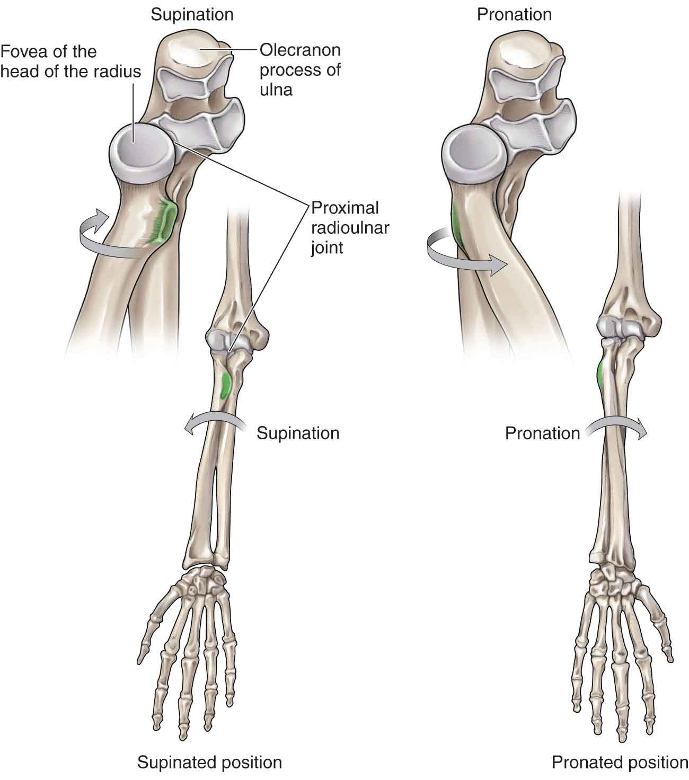

From https://musculoskeletalkey.com/elbow-10/

Proper mechanical models of this bones and joints involve close-kinematic constraints, see for example the explicit schema below.

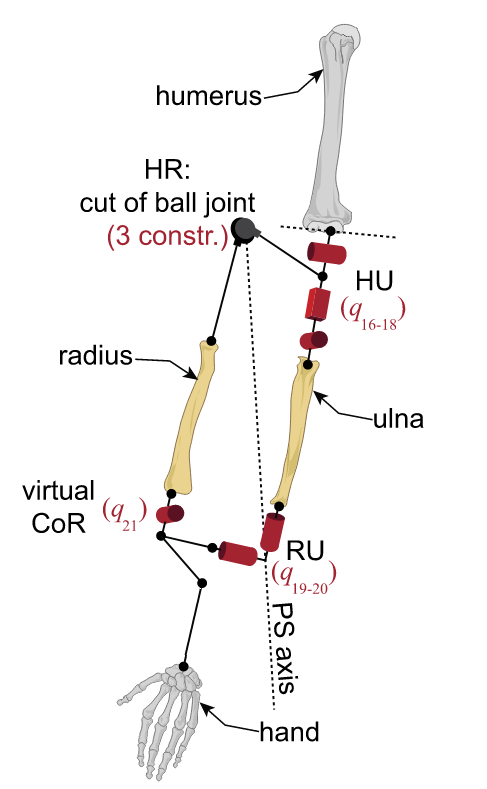

From (Laitenberger, M., Raison, M., Périé, D., & Begon, M. (2015). Refinement of the upper limb joint kinematics and dynamics using a subject-specific closed-loop forearm model. Multibody System Dynamics, 33(4), 413-438).

This can be seen as a more sophisticated version of the classical *parallelogram* structure, which enables stiff linkages of light R2 robots, has depicted below:

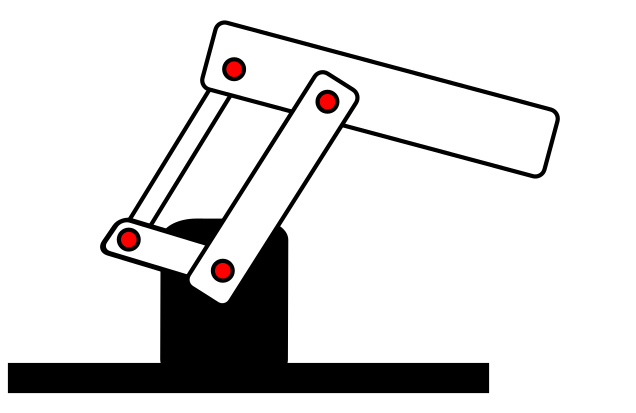

This robot has 4 moving links, with 4 joints, enabling a total of 2 degrees of freedom. It can be reprented with an extended configuration of dimension 12 (x,y,theta of each center of rotation). 

**Implement the display and constraint functions, allow to optimize and visualize the search for a configuration where the end-effector of the R2 robot reaches an arbitrary 2d target.**